In [1]:
!pip freeze

absl-py==0.8.1
alabaster==0.7.10
albumentations==1.0.0
anaconda-client==1.6.14
anaconda-project==0.8.2
asn1crypto==0.24.0
astor==0.8.0
astroid==1.6.3
astropy==3.0.2
attrs==18.1.0
autovizwidget==0.13.1
Babel==2.5.3
backcall==0.1.0
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.6.0
bitarray==0.8.1
bkcharts==0.2
blaze==0.11.3
bleach==2.1.3
bokeh==1.0.4
boto==2.48.0
boto3==1.10.19
botocore==1.13.19
Bottleneck==1.2.1
cachetools==3.1.1
certifi==2019.11.28
cffi==1.11.5
chardet==3.0.4
click==6.7
cloudpickle==0.5.3
clyent==1.2.2
colorama==0.3.9
contextlib2==0.5.5
cryptography==2.8
cycler==0.10.0
Cython==0.28.2
cytoolz==0.9.0.1
dask==2021.3.0
datashape==0.5.4
decorator==4.3.0
defusedxml==0.6.0
distributed==1.21.8
docutils==0.14
efficientnet==1.0.0
entrypoints==0.2.3
enum34==1.1.6
environment-kernels==1.1.1
et-xmlfile==1.0.1
fastcache==1.0.2
filelock==3.0.4
Flask==1.0.2
Flask-Cors==3.0.4
future==0.18.2
gast==0.2.2
gevent==1.3.0
glob2==0.6
gmpy2==2.0.8
google-auth==1.7.1
google-auth-o

In [1]:
from datagen import generator, tumor_generator
from model import build_seg_model

Segmentation Models: using `keras` framework.


Using TensorFlow backend.


In [2]:
import segmentation_models as sm
sm.set_framework('tf.keras')

In [3]:
import tensorflow.keras.backend as k
import gc

In [ ]:
import tensorflow.

In [4]:
import os, glob
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import IPython
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img, array_to_img
import PIL
from PIL import ImageOps
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (10,8)

1 Physical GPUs, 1 Logical GPUs


In [5]:
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [6]:
## config

BASE_PATH = glob.glob('/home/centos/jupyter/pathology/data/img/patch_overlap_global_512/*/*') # all patients
TRAIN_PATIENT_PATH = shuffle(BASE_PATH,random_state=311)[:int(0.60*len(BASE_PATH))]
VALID_PATIENT_PATH = shuffle(BASE_PATH,random_state=311)[int(0.60*len(BASE_PATH)):int(0.80*len(BASE_PATH))]
TEST_PATIENT_PATH = shuffle(BASE_PATH,random_state=311)[int(0.80*len(BASE_PATH)):]

TRAIN_IMG_PATH = []; TRAIN_TARGET_PATH = []
for x in TRAIN_PATIENT_PATH:
    TRAIN_TARGET_PATH.extend(glob.glob(x+'/mask/*_p[2].png'))
    TRAIN_TARGET_PATH.extend(shuffle(glob.glob(x+'/mask/*_p[3].png')[:30],random_state=311))
    TRAIN_TARGET_PATH.extend(glob.glob(x+'/mask/*_p[4].png')[:5])
VALID_IMG_PATH = []; VALID_TARGET_PATH = []
for x in VALID_PATIENT_PATH:
    VALID_TARGET_PATH.extend(glob.glob(x+'/mask/*_p[2].png'))
    VALID_TARGET_PATH.extend(shuffle(glob.glob(x+'/mask/*_p[3].png')[:30],random_state=311))
    VALID_TARGET_PATH.extend(glob.glob(x+'/mask/*_p[4].png')[:5])
    
TEST_IMG_PATH = []; TEST_TARGET_PATH = []
for x in TEST_PATIENT_PATH:
    TEST_TARGET_PATH.extend(glob.glob(x+'/mask/*_p[2].png'))
    TEST_TARGET_PATH.extend(shuffle(glob.glob(x+'/mask/*_p[3].png')[:30],random_state=311))
    TEST_TARGET_PATH.extend(glob.glob(x+'/mask/*_p[4].png')[:5])
    
TRAIN_ZIP = shuffle(
    [('/'.join(x.split('/')[:-2])+'/image/'+x.split('/')[-1].replace('_p2.png','.png').replace('_p3.png','.png').replace('_p4.png','.png'),x) for x in TRAIN_TARGET_PATH],
    random_state=311
)
VALID_ZIP = shuffle(
    [('/'.join(x.split('/')[:-2])+'/image/'+x.split('/')[-1].replace('_p2.png','.png').replace('_p3.png','.png').replace('_p4.png','.png'),x) for x in VALID_TARGET_PATH]
    ,random_state=311
)
TEST_ZIP = shuffle(
    [('/'.join(x.split('/')[:-2])+'/image/'+x.split('/')[-1].replace('_p2.png','.png').replace('_p3.png','.png').replace('_p4.png','.png'),x) for x in TEST_TARGET_PATH]
    ,random_state=311
)

BATCH_SIZE = 32
INPUT_SHAPE = (512,512)
NUM_CLASSES = 2
EPOCHS = 100

In [7]:
print(len([x for x in TRAIN_ZIP if '_p2' in x[1]]))
print(len([x for x in TRAIN_ZIP if '_p3' in x[1]]))
print(len([x for x in TRAIN_ZIP if '_p4' in x[1]]))

print(len([x for x in VALID_ZIP if '_p2' in x[1]]))
print(len([x for x in VALID_ZIP if '_p3' in x[1]]))
print(len([x for x in VALID_ZIP if '_p4' in x[1]]))

print(len([x for x in TEST_ZIP if '_p2' in x[1]]))
print(len([x for x in TEST_ZIP if '_p3' in x[1]]))
print(len([x for x in TEST_ZIP if '_p4' in x[1]]))

2954
2365
435
756
763
145
706
758
145


In [8]:
print(len(TRAIN_ZIP),len(VALID_ZIP),len(TEST_ZIP))

5754 1664 1609


In [9]:
train_gen = generator(BATCH_SIZE,INPUT_SHAPE,TRAIN_ZIP,is_train=True)
valid_gen = generator(BATCH_SIZE,INPUT_SHAPE,VALID_ZIP,is_train=False)
test_gen = generator(BATCH_SIZE,INPUT_SHAPE,TEST_ZIP,is_train=False)

In [10]:
batch_x,batch_y = train_gen.__getitem__(5)

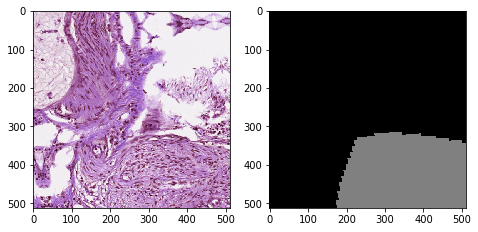

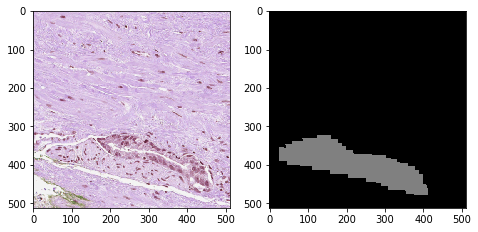

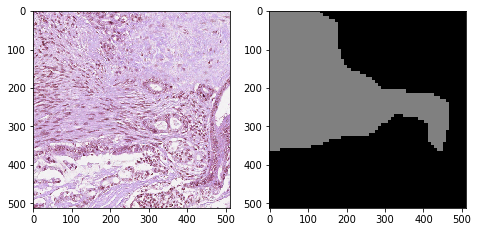

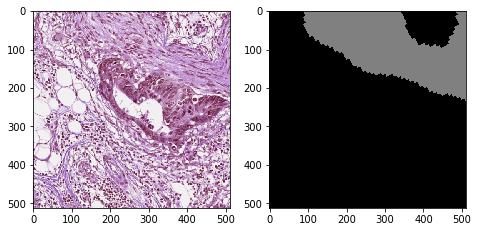

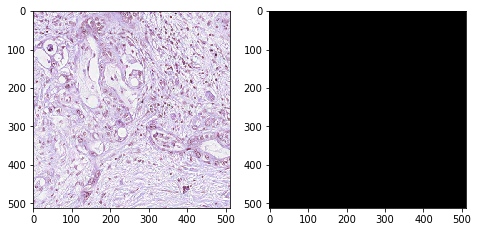

In [11]:
for idx in range(5,10):
    plt.figure(figsize = (12,6));
    d = np.unique(batch_x,return_counts=True)
    plt.subplot(1,3,1);plt.imshow((255*batch_x[idx]).astype(np.int32))
    plt.subplot(1,3,2);plt.imshow(np.squeeze(batch_y[idx],axis=-1),vmin=0,vmax=2)
    #plt.subplot(1,3,3);plt.bar(d[0],d[1])

---

### TRAIN BY KERAS-TUNER

In [13]:
from kerastuner import Hyperband, HyperParameter, HyperParameters, HyperModel

In [14]:
def build_model(hp):
    dice_loss = sm.losses.DiceLoss()
    focal_loss = sm.losses.BinaryFocalLoss(alpha=0.25, gamma=6.0)
    total_loss = dice_loss + focal_loss
    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
    
    BACKBONE = hp.Choice('backbone',['inceptionresnetv2','inceptionv3'])
    model = sm.Unet(BACKBONE,input_shape=(512,512,3),classes=1,activation='sigmoid',encoder_weights='imagenet')
    '''
    if hp.Choice('optimizer',['adam','sgd'])=='adam':
        model.compile(Adam(lr=hp.Choice('learning_rate',[1e-3,1e-4,1e-5])),total_loss,metrics)
    else:
        model.compile(SGD(lr=hp.Choice('learning_rate',[1e-3,1e-4,1e-5])),total_loss,metrics)
    '''
    model.compile(optimizer = Adam(hp.Float('learning_rate',1e-4,1e-2,sampling='log')),loss=total_loss,metrics=metrics)
    return model

In [17]:
## CALLBACK
model_path='./data/model/seg_tumor_0718.hdf5'
mc = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
es = EarlyStopping(monitor = 'val_loss',patience = 4)
lr = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실을 기준으로 callback이 호출됩니다
    factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
    patience=2,         # epoch 4 동안 개선되지 않으면 callback이 호출됩니다
)
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)
callbacks_list = [mc,es,lr,ClearTrainingOutput()]

In [19]:
tuner = Hyperband(
    hypermodel=build_model,
    objective="val_loss",
    max_epochs=10,
    factor=3,
    hyperband_iterations=1,
    distribution_strategy=tf.distribute.MirroredStrategy(),
    directory='tumor_segmentation'
)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

In [23]:
tuner.search(
    train_gen, 
    validation_data=valid_gen, 
    epochs=10,
    callbacks = callbacks_list
)

INFO:tensorflow:Oracle triggered exit


In [24]:
tuner.results_summary()

In [25]:
best_hp = tuner.get_best_hyperparameters()[0]


In [27]:
best_hp.values

{'backbone': 'inceptionv3',
 'learning_rate': 0.0024404408211669984,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [28]:
best_model = tuner.hypermodel.build(best_hp)

In [31]:
model_path = './data/model/seg_tumor_tuner_inceptionv3.hdf5'
mc = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
es = EarlyStopping(monitor = 'val_loss',patience = 8)
lr = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실을 기준으로 callback이 호출됩니다
    factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
    patience=4,         # epoch 4 동안 개선되지 않으면 callback이 호출됩니다
)
callbacks_list = [mc,es,lr]

In [32]:
history = best_model.fit(
    train_gen,
    validation_data = valid_gen,
    callbacks = callbacks_list,
    epochs=EPOCHS,
    max_queue_size=15,
    use_multiprocessing=True,
    verbose=1
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 39 steps, validate for 18 steps
Epoch 1/100
38/39 [============================>.] - ETA: 17:45 - loss: 0.6749 - iou_score: 0.2371 - f1-score: 0.383 - ETA: 12:25 - loss: 0.6656 - iou_score: 0.2426 - f1-score: 0.390 - ETA: 10:08 - loss: 0.6544 - iou_score: 0.2573 - f1-score: 0.408 - ETA: 9:05 - loss: 0.6604 - iou_score: 0.2634 - f1-score: 0.416 - ETA: 8:32 - loss: 0.6605 - iou_score: 0.2756 - f1-score: 0.43 - ETA: 7:52 - loss: 0.6506 - iou_score: 0.2969 - f1-score: 0.45 - ETA: 7:34 - loss: 0.6386 - iou_score: 0.3141 - f1-score: 0.47 - ETA: 7:08 - loss: 0.6299 - iou_score: 0.3239 - f1-score: 0.48 - ETA: 6:45 - loss: 0.6365 - iou_score: 0.3190 - f1-score: 0.48 - ETA: 6:22 - loss: 0.6356 - iou_score: 0.3195 - f1-score: 0.48 - ETA: 6:02 - loss: 0.6219 - iou_score: 0.3353 - f1-score: 0.49 - ETA: 5:43 - loss: 0.6116 - iou_score: 0.3494 - f1-score: 0.51 - ETA: 5:23 - loss: 0.6076 - iou_score: 0.3541 - f1-score: 0.51 - ETA: 5:11 - loss

38/39 [============================>.] - ETA: 53:14 - loss: 0.3818 - iou_score: 0.5566 - f1-score: 0.715 - ETA: 29:03 - loss: 0.3542 - iou_score: 0.5911 - f1-score: 0.742 - ETA: 20:44 - loss: 0.3209 - iou_score: 0.6349 - f1-score: 0.774 - ETA: 16:44 - loss: 0.3218 - iou_score: 0.6382 - f1-score: 0.777 - ETA: 14:16 - loss: 0.3088 - iou_score: 0.6540 - f1-score: 0.789 - ETA: 12:34 - loss: 0.3307 - iou_score: 0.6326 - f1-score: 0.772 - ETA: 11:32 - loss: 0.3262 - iou_score: 0.6415 - f1-score: 0.779 - ETA: 10:29 - loss: 0.3274 - iou_score: 0.6397 - f1-score: 0.778 - ETA: 9:43 - loss: 0.3406 - iou_score: 0.6243 - f1-score: 0.765 - ETA: 8:55 - loss: 0.3319 - iou_score: 0.6333 - f1-score: 0.77 - ETA: 8:13 - loss: 0.3272 - iou_score: 0.6360 - f1-score: 0.77 - ETA: 7:45 - loss: 0.3265 - iou_score: 0.6356 - f1-score: 0.77 - ETA: 7:17 - loss: 0.3247 - iou_score: 0.6372 - f1-score: 0.77 - ETA: 6:53 - loss: 0.3256 - iou_score: 0.6387 - f1-score: 0.77 - ETA: 6:25 - loss: 0.3243 - iou_score: 0.6388 -

38/39 [============================>.] - ETA: 48:59 - loss: 0.2125 - iou_score: 0.7509 - f1-score: 0.857 - ETA: 27:05 - loss: 0.2408 - iou_score: 0.7210 - f1-score: 0.837 - ETA: 20:15 - loss: 0.2294 - iou_score: 0.7342 - f1-score: 0.846 - ETA: 17:09 - loss: 0.2282 - iou_score: 0.7339 - f1-score: 0.846 - ETA: 14:53 - loss: 0.2213 - iou_score: 0.7411 - f1-score: 0.851 - ETA: 13:29 - loss: 0.2313 - iou_score: 0.7336 - f1-score: 0.846 - ETA: 12:06 - loss: 0.2325 - iou_score: 0.7341 - f1-score: 0.846 - ETA: 11:15 - loss: 0.2295 - iou_score: 0.7378 - f1-score: 0.848 - ETA: 10:35 - loss: 0.2260 - iou_score: 0.7421 - f1-score: 0.851 - ETA: 10:09 - loss: 0.2273 - iou_score: 0.7422 - f1-score: 0.851 - ETA: 9:44 - loss: 0.2287 - iou_score: 0.7404 - f1-score: 0.850 - ETA: 9:05 - loss: 0.2389 - iou_score: 0.7279 - f1-score: 0.84 - ETA: 8:42 - loss: 0.2395 - iou_score: 0.7258 - f1-score: 0.84 - ETA: 8:18 - loss: 0.2369 - iou_score: 0.7275 - f1-score: 0.84 - ETA: 7:54 - loss: 0.2323 - iou_score: 0.73

38/39 [============================>.] - ETA: 1:28:01 - loss: 0.1386 - iou_score: 0.8398 - f1-score: 0.912 - ETA: 48:35 - loss: 0.1487 - iou_score: 0.8292 - f1-score: 0.9066  - ETA: 35:37 - loss: 0.1634 - iou_score: 0.8105 - f1-score: 0.895 - ETA: 28:45 - loss: 0.1586 - iou_score: 0.8169 - f1-score: 0.899 - ETA: 24:50 - loss: 0.1630 - iou_score: 0.8092 - f1-score: 0.894 - ETA: 21:55 - loss: 0.1640 - iou_score: 0.8082 - f1-score: 0.893 - ETA: 19:45 - loss: 0.1699 - iou_score: 0.8016 - f1-score: 0.889 - ETA: 17:56 - loss: 0.1726 - iou_score: 0.7972 - f1-score: 0.886 - ETA: 16:31 - loss: 0.1780 - iou_score: 0.7932 - f1-score: 0.884 - ETA: 15:23 - loss: 0.1791 - iou_score: 0.7906 - f1-score: 0.882 - ETA: 14:16 - loss: 0.1788 - iou_score: 0.7890 - f1-score: 0.881 - ETA: 13:23 - loss: 0.1816 - iou_score: 0.7858 - f1-score: 0.879 - ETA: 12:44 - loss: 0.1836 - iou_score: 0.7846 - f1-score: 0.879 - ETA: 11:58 - loss: 0.1850 - iou_score: 0.7841 - f1-score: 0.878 - ETA: 11:16 - loss: 0.1854 - iou

38/39 [============================>.] - ETA: 1:16:50 - loss: 0.1586 - iou_score: 0.8086 - f1-score: 0.894 - ETA: 43:53 - loss: 0.1648 - iou_score: 0.7999 - f1-score: 0.8888  - ETA: 31:24 - loss: 0.1558 - iou_score: 0.8134 - f1-score: 0.897 - ETA: 25:18 - loss: 0.1570 - iou_score: 0.8084 - f1-score: 0.893 - ETA: 21:37 - loss: 0.1556 - iou_score: 0.8117 - f1-score: 0.895 - ETA: 19:10 - loss: 0.1565 - iou_score: 0.8112 - f1-score: 0.895 - ETA: 17:17 - loss: 0.1590 - iou_score: 0.8078 - f1-score: 0.893 - ETA: 15:47 - loss: 0.1635 - iou_score: 0.8029 - f1-score: 0.890 - ETA: 14:38 - loss: 0.1655 - iou_score: 0.8019 - f1-score: 0.889 - ETA: 13:41 - loss: 0.1645 - iou_score: 0.8039 - f1-score: 0.891 - ETA: 12:53 - loss: 0.1599 - iou_score: 0.8096 - f1-score: 0.894 - ETA: 12:01 - loss: 0.1634 - iou_score: 0.8064 - f1-score: 0.892 - ETA: 11:19 - loss: 0.1602 - iou_score: 0.8106 - f1-score: 0.895 - ETA: 10:44 - loss: 0.1638 - iou_score: 0.8077 - f1-score: 0.893 - ETA: 10:19 - loss: 0.1611 - iou

38/39 [============================>.] - ETA: 1:14:08 - loss: 0.1251 - iou_score: 0.8463 - f1-score: 0.916 - ETA: 42:06 - loss: 0.1416 - iou_score: 0.8310 - f1-score: 0.9077  - ETA: 31:15 - loss: 0.1310 - iou_score: 0.8460 - f1-score: 0.916 - ETA: 25:57 - loss: 0.1424 - iou_score: 0.8333 - f1-score: 0.908 - ETA: 22:07 - loss: 0.1435 - iou_score: 0.8297 - f1-score: 0.906 - ETA: 20:00 - loss: 0.1575 - iou_score: 0.8134 - f1-score: 0.896 - ETA: 18:34 - loss: 0.1573 - iou_score: 0.8147 - f1-score: 0.897 - ETA: 16:54 - loss: 0.1593 - iou_score: 0.8115 - f1-score: 0.895 - ETA: 15:09 - loss: 0.1551 - iou_score: 0.8170 - f1-score: 0.898 - ETA: 14:12 - loss: 0.1538 - iou_score: 0.8179 - f1-score: 0.899 - ETA: 13:23 - loss: 0.1558 - iou_score: 0.8150 - f1-score: 0.897 - ETA: 12:29 - loss: 0.1549 - iou_score: 0.8165 - f1-score: 0.898 - ETA: 11:46 - loss: 0.1538 - iou_score: 0.8177 - f1-score: 0.899 - ETA: 11:02 - loss: 0.1537 - iou_score: 0.8171 - f1-score: 0.899 - ETA: 10:17 - loss: 0.1549 - iou

38/39 [============================>.] - ETA: 1:32:21 - loss: 0.0985 - iou_score: 0.8815 - f1-score: 0.937 - ETA: 51:57 - loss: 0.1190 - iou_score: 0.8572 - f1-score: 0.9230  - ETA: 37:05 - loss: 0.1187 - iou_score: 0.8555 - f1-score: 0.922 - ETA: 29:22 - loss: 0.1251 - iou_score: 0.8466 - f1-score: 0.916 - ETA: 25:00 - loss: 0.1260 - iou_score: 0.8451 - f1-score: 0.915 - ETA: 21:58 - loss: 0.1257 - iou_score: 0.8444 - f1-score: 0.915 - ETA: 19:20 - loss: 0.1284 - iou_score: 0.8422 - f1-score: 0.914 - ETA: 17:36 - loss: 0.1277 - iou_score: 0.8432 - f1-score: 0.914 - ETA: 16:10 - loss: 0.1276 - iou_score: 0.8446 - f1-score: 0.915 - ETA: 14:59 - loss: 0.1297 - iou_score: 0.8430 - f1-score: 0.914 - ETA: 13:43 - loss: 0.1335 - iou_score: 0.8394 - f1-score: 0.912 - ETA: 12:47 - loss: 0.1346 - iou_score: 0.8382 - f1-score: 0.911 - ETA: 12:11 - loss: 0.1353 - iou_score: 0.8372 - f1-score: 0.911 - ETA: 11:30 - loss: 0.1361 - iou_score: 0.8366 - f1-score: 0.910 - ETA: 10:48 - loss: 0.1376 - iou

38/39 [============================>.] - ETA: 1:19:18 - loss: 0.1518 - iou_score: 0.8180 - f1-score: 0.899 - ETA: 44:50 - loss: 0.1271 - iou_score: 0.8442 - f1-score: 0.9153  - ETA: 33:18 - loss: 0.1254 - iou_score: 0.8471 - f1-score: 0.917 - ETA: 26:14 - loss: 0.1259 - iou_score: 0.8461 - f1-score: 0.916 - ETA: 22:21 - loss: 0.1320 - iou_score: 0.8390 - f1-score: 0.912 - ETA: 19:25 - loss: 0.1290 - iou_score: 0.8436 - f1-score: 0.915 - ETA: 17:34 - loss: 0.1294 - iou_score: 0.8431 - f1-score: 0.914 - ETA: 16:13 - loss: 0.1315 - iou_score: 0.8408 - f1-score: 0.913 - ETA: 14:45 - loss: 0.1323 - iou_score: 0.8393 - f1-score: 0.912 - ETA: 13:38 - loss: 0.1318 - iou_score: 0.8398 - f1-score: 0.912 - ETA: 12:50 - loss: 0.1315 - iou_score: 0.8405 - f1-score: 0.913 - ETA: 12:00 - loss: 0.1326 - iou_score: 0.8384 - f1-score: 0.912 - ETA: 11:29 - loss: 0.1322 - iou_score: 0.8382 - f1-score: 0.911 - ETA: 10:48 - loss: 0.1310 - iou_score: 0.8403 - f1-score: 0.913 - ETA: 10:09 - loss: 0.1319 - iou

In [33]:
best_model.evaluate(test_gen)

  ...
    to  
  ['...']
15/15 [==============================] - ETA: 1:35 - loss: 0.1925 - iou_score: 0.7860 - f1-score: 0.88 - ETA: 56s - loss: 0.1965 - iou_score: 0.7729 - f1-score: 0.8718 - ETA: 45s - loss: 0.2057 - iou_score: 0.7753 - f1-score: 0.873 - ETA: 35s - loss: 0.2400 - iou_score: 0.7530 - f1-score: 0.858 - ETA: 27s - loss: 0.3244 - iou_score: 0.7002 - f1-score: 0.818 - ETA: 24s - loss: 0.3232 - iou_score: 0.6908 - f1-score: 0.812 - ETA: 20s - loss: 0.3120 - iou_score: 0.6948 - f1-score: 0.815 - ETA: 17s - loss: 0.2968 - iou_score: 0.7064 - f1-score: 0.824 - ETA: 13s - loss: 0.3015 - iou_score: 0.7032 - f1-score: 0.822 - ETA: 11s - loss: 0.2975 - iou_score: 0.7081 - f1-score: 0.825 - ETA: 8s - loss: 0.2926 - iou_score: 0.7125 - f1-score: 0.829 - ETA: 6s - loss: 0.2839 - iou_score: 0.7196 - f1-score: 0.83 - ETA: 4s - loss: 0.2753 - iou_score: 0.7263 - f1-score: 0.83 - ETA: 2s - loss: 0.2715 - iou_score: 0.7297 - f1-score: 0.84 - 30s 2s/step - loss: 0.2664 - iou_score: 0.73

[0.26638873318831124, 0.7339079, 0.84378505]

---

### TRAIN BY FIT

In [10]:
CLASS = 'TUMOR'
MODE = 'Camelyon16_Augmentv02_DiceFocalLoss_alpha_025_gamma_6'
BACKBONE = 'inceptionresnetv2'
model_path = './data/model/seg_nerve_0722_inceptionresnetv2_transpose.hdf5'
encoder_weight = 'imagenet'
IMAGE_SIZE = 512
CHANNEL = 3
LR = 0.002
EPOCHS = 200

preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes = 1
activation = 'sigmoid' 

#create model
model = sm.Unet(BACKBONE,decoder_block_type='transpose', input_shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNEL),classes=n_classes, activation=activation,encoder_weights=encoder_weight)

In [13]:
## MULTIGPU
#strategy = tf.distribute.MirroredStrategy()
#print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
#with strategy.scope():
#    model = sm.Unet(BACKBONE, input_shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNEL),classes=n_classes, activation=activation,encoder_weights=encoder_weight)
#    model.compile(optim, total_loss, metrics)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:

In [11]:
from tensorflow.keras.callbacks import Callback
# define optomizer
optim = Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()

# default focal_loss (alpha=0.25, gamma=2.0)
focal_loss = sm.losses.BinaryFocalLoss(alpha=0.25, gamma=6.0)
total_loss = dice_loss + focal_loss


# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
#metrics = [my_metric]
class ClearMemory(Callback):
    def on_epoch_end(self,epoch,logs=None):
        gc.collect()
        k.clear_session()
        
mc = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
es = EarlyStopping(monitor = 'val_loss',patience = 10)
lr = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실을 기준으로 callback이 호출됩니다
    factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
    patience=5,         # epoch 4 동안 개선되지 않으면 callback이 호출됩니다
)
callbacks_list = [mc,es,lr,ClearMemory()]
#mc = ModelCheckpoint(history_files); lr = ReduceLROnPlateau()
#callback_list = [mc,lr]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Total params: 65,118,705
Trainable params: 65,056,177
Non-trainable params: 62,528
__________________________________________________________________________________________________


In [14]:
model.load_weights('./data/model/seg_nerve_0722_inceptionresnetv2_transpose.hdf5')

In [15]:
history = model.fit(train_gen, 
                    epochs = EPOCHS,
                    validation_data=valid_gen,
                    callbacks=callbacks_list,
                    max_queue_size=20,
                    workers=10,
                    #use_multiprocessing=True,
                    verbose=1
                   )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 179 steps, validate for 52 steps
Epoch 1/200
178/179 [============================>.] - ETA: 1s - loss: 0.1834 - iou_score: 0.7578 - f1-score: 0.8606
Epoch 00001: val_loss improved from inf to 0.29623, saving model to ./data/model/seg_nerve_0722_inceptionresnetv2_transpose.hdf5
179/179 [==============================] - 427s 2s/step - loss: 0.1832 - iou_score: 0.7580 - f1-score: 0.8607 - val_loss: 0.2962 - val_iou_score: 0.6510 - val_f1-score: 0.7822
Epoch 2/200
178/179 [============================>.] - ETA: 1s - loss: 0.2064 - iou_score: 0.7302 - f1-score: 0.8423
Epoch 00002: val_loss improved from 0.29623 to 0.29392, saving model to ./data/model/seg_nerve_0722_inceptionresnetv2_transpose.hdf5
179/179 [==============================] - 397s 2s/step - loss: 0.2060 - iou_score: 0.7307 - f1-score: 0.8426 - val_loss: 0.2939 - val_iou_score: 0.6495 - val_f1-score: 0.7816
Epoch 3/200
178/179 [============================>.] - ETA:

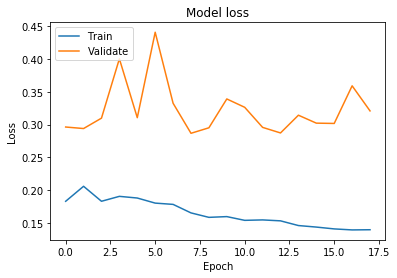

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

In [17]:
e_val = model.evaluate(test_gen)
print(f'IOU Score : {e_val[1]:.2f} F1-Score : {e_val[2]:.2f}')

  ...
    to  
  ['...']
50/50 [==============================] - 345s 7s/step - loss: 0.3147 - iou_score: 0.6011 - f1-score: 0.7426
IOU Score : 0.60 F1-Score : 0.74


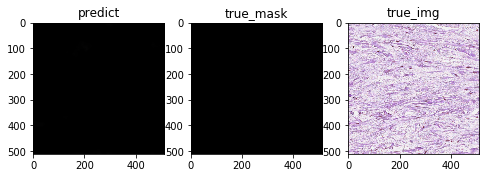

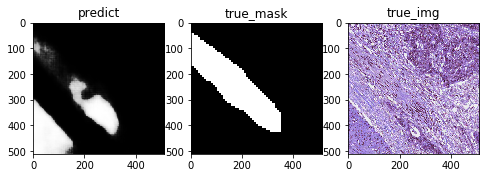

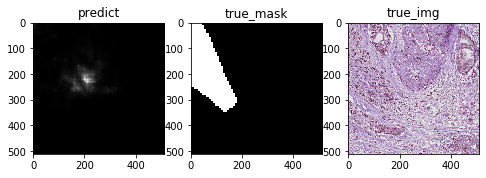

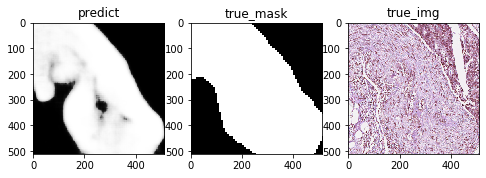

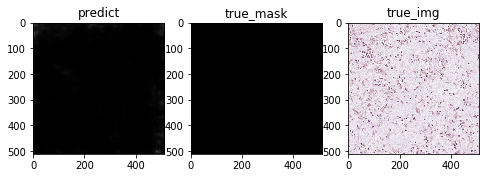

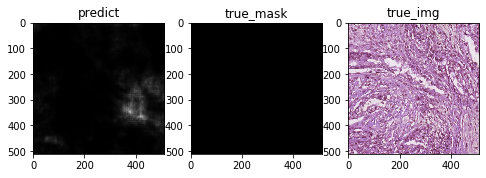

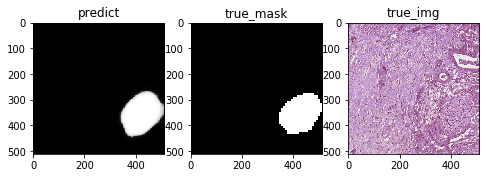

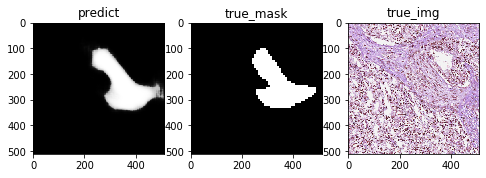

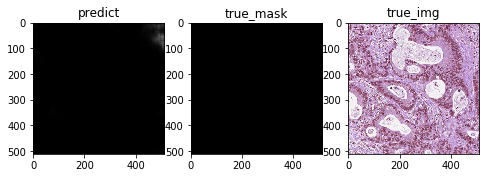

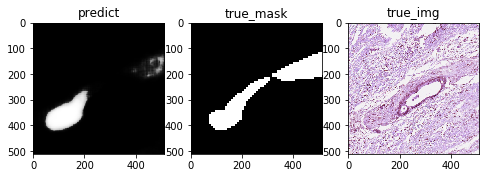

In [18]:
batch_x,batch_y=  test_gen.__getitem__(0)
for i in range(10,20):

    img,msk = batch_x[i],batch_y[i]
    img = np.expand_dims(img,axis=0)
    pr_msk = model.predict(img)
    pr_msk = np.squeeze(pr_msk)
    plt.figure(figsize = (8,6))
    plt.subplot(1,3,1); plt.title('predict'); plt.imshow(pr_msk)
    plt.subplot(1,3,2); plt.title('true_mask'); plt.imshow(np.squeeze(batch_y[i]))
    plt.subplot(1,3,3); plt.title('true_img'); plt.imshow(np.squeeze((255*img).astype(np.uint8)))

#pr_msk = np.expand_dims(pr_msk,axis=-1)


---